In [1]:
# ! pip install pretty_midi

In [1]:
import os
import io
import re
import random
import string
import zipfile
import requests
import numpy as np
import pandas as pd
import pretty_midi
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from typing import List
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from gensim.models import Word2Vec, KeyedVectors
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Training - lyrics + melody (.mid files with notes, instruments, etc.)
# Test - generate lyrics for melody

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Or\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Get midi files folder and train/test .csv files
def download_and_extract(repo_url, output_path):
    # check if the output path exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # download ZIP file
    response = requests.get(repo_url)
    if response.status_code == 200:
        # Extract from ZIP file
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            zip_ref.extractall(output_path)
        print(f"Files extracted to: {output_path}")
    else:
        print(f"Failed to download ZIP file: {response.status_code}")

# Example usage
repo_url = "https://github.com/Or-Gindes/DeepLearningBGU/raw/main/assignment3/Archive.zip?raw=true"  # link to the ZIP file
output_path = "./"  # output directory

download_and_extract(repo_url, output_path)

Files extracted to: ./


In [3]:
class MIDIDataset(Dataset):
  """
  Dataset object for MIDI files.
  Attributes:
    dataset: pandas dataframe with columns: artist, title, lyricsx
    path_to_mids: path to folder with MIDI files
  """
  def __init__(self, path_to_mids: str, dataset: pd.DataFrame):
    self.dataset = dataset.copy()
    self.parse_dataset(path_to_mids)

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    return self.dataset.iloc[idx, :]

  def __getattr__(self, name):
      if name in self.dataset.columns:
          return self.dataset[name]
      raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")

  def get_item_from_artist_song_name(self, artist, song_name):
    """
    returns item from dataset based on artist and song name
    :param artist: artist name
    :param song_name: song name
    """
    return self.dataset.loc[self.dataset['artist'] == artist and self.dataset['title'] == song_name, :]

  def parse_dataset(self, path_to_mids):
    """
    Parses dataset and adds:
      directory column - which contains path to MIDI file.
      parsed_mid column - which contains parsed MIDI data.
    """
    self.dataset['directory'] = (path_to_mids + self.dataset.iloc[:, 0].str.strip() + "_-_" + self.dataset.iloc[:, 1].str.strip()).str.strip().str.replace(' ', '_') + ".mid"
    files = []
    for file in os.listdir(path_to_mids):
      if file.endswith('.mid'):
        files.append(os.path.join(path_to_mids, file))
    cleaned_file_names = [re.sub(r'_-_live.*|_-_extended.*|_-_violin.*|-2.mid', '.mid', file.lower()) for file in files]

    directory_dict = dict(zip(cleaned_file_names, files))
    self.dataset['directory'] = [directory_dict.get(song) for song in self.dataset['directory']]
    self.dataset['parsed_mid'] = self.dataset['directory'].map(MIDIDataset.get_midi_data)
    self.dataset = self.dataset.dropna()
    self.dataset.reset_index(drop=True, inplace=True)

  @staticmethod
  def get_midi_data(path_to_mid: str) -> pd.DataFrame:
    """
    Given a path extract features from MIDI file
    :param path_to_mid: path to MIDI file
    :param start_time: start time in seconds from the begining of the song
    :param end_time: end time in seconds from the begining of the song
    :return:
    """
      # Load MIDI file, handling potential KeySignatureErrors
    try:
      midi_data = pretty_midi.PrettyMIDI(path_to_mid)
    except Exception as e:
      print(f"Skipping file {path_to_mid}: {e}")
      return None  # or handle the error differently as needed

    # remove noise
    midi_data.remove_invalid_notes()

    # parse midi to df
    instrument_col = []
    pitch_col = []
    velocity_col = []
    start_col = []
    end_col = []
    for i, instrument in enumerate(midi_data.instruments):
      for j, note in enumerate(instrument.notes):
        start_col.append(note.start)
        end_col.append(note.end)
        instrument_col.append(MIDIDataset.parse_instrument(instrument.name))
        pitch_col.append(note.pitch)
        velocity_col.append(note.velocity)

    end_col = np.array(end_col)
    start_col = np.array(start_col)/np.max(end_col)
    end_col /= np.max(end_col)
    pitch_col = np.array(pitch_col)/127
    velocity_col = np.array(velocity_col)/127

    df = pd.DataFrame({"start": start_col,
                      "end": end_col,
                      "instrument": instrument_col,
                      "duration": end_col - start_col,
                      "pitch": pitch_col,
                      "velocity": velocity_col
                      })

    df = df.sort_values(by=["start", "end"])
    df = df.reset_index(drop=True)

    ohe = OneHotEncoder(categories=[['guitar', 'strings', 'keyboard', 'horns', 'drums', 'melody', 'other']])
    ohe_columns = ohe.fit_transform(df[["instrument"]])
    df.drop(columns=['instrument'], inplace=True)
    df = np.concatenate((df.values, ohe_columns.toarray()), axis=1)
    return df

  @staticmethod
  def parse_instrument(instrument):
    if re.search(r'guitar|bass', instrument.lower()):
      return 'guitar'
    elif re.search(r'violin|cello', instrument.lower()):
      return 'strings'
    elif re.search(r'piano|keyboard|organ', instrument.lower()):
      return 'keyboard'
    elif re.search(r'sax|saxophone|trump.*|clarinet|flute', instrument.lower()):
      return 'horns'
    elif re.search(r'drum.*', instrument.lower()):
      return 'drums'
    elif re.search(r'melody', instrument.lower()):
      return 'melody'
    else:
      return 'other'

In [4]:
# Load train and test lyrics
def load_lyrics(path: str) -> pd.DataFrame:
  df = pd.read_csv(path, header=None, usecols=[0,1,2])
  df.columns = ["artist", "title", "lyrics"]
  return df

# Load train and test MIDI files, create validation set
train = load_lyrics("lyrics_train_set.csv")
unique_artists = np.array(list(set(train.artist)))
number_of_artists_in_validation = int(len(unique_artists) * 0.1)
random_choice = np.random.choice(range(number_of_artists_in_validation), number_of_artists_in_validation, replace=False)

validation = train[train.artist.isin(unique_artists[random_choice])]
validation.reset_index(drop=True, inplace=True)

train = train[~train.artist.isin(unique_artists[random_choice])]
train.reset_index(drop=True, inplace=True)

train = MIDIDataset("./midi_files/", train)
validation = MIDIDataset("./midi_files/", validation)

test = load_lyrics("lyrics_test_set.csv")
test = MIDIDataset("./midi_files/", test)

print("------------------------------------------\n-----------------Train:-------------------\n------------------------------------------")
display(train.dataset.info())
print("------------------------------------------\n-----------------Validation:--------------\n------------------------------------------")
display(validation.dataset.info())
print("------------------------------------------\n-----------------Test:--------------------\n------------------------------------------")
display(test.dataset.info())

C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature ch

Skipping file ./midi_files/Beastie_Boys_-_Girls.mid: Could not decode key with 1 flats and mode 255


C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Skipping file ./midi_files/Billy_Joel_-_Movin'_Out.mid: data byte must be in range 0..127
Skipping file ./midi_files/Billy_Joel_-_Pressure.mid: data byte must be in range 0..127


C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature ch

Skipping file ./midi_files/Dan_Fogelberg_-_Leader_of_the_Band.mid: Could not decode key with 4 flats and mode 255


C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature ch

Skipping file ./midi_files/Brian_McKnight_-_On_The_Down_Low.mid: 


C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature ch

Skipping file ./midi_files/Aaron_Neville_-_Tell_It_Like_It_Is.mid: data byte must be in range 0..127


C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


------------------------------------------
-----------------Train:-------------------
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artist      548 non-null    object
 1   title       548 non-null    object
 2   lyrics      548 non-null    object
 3   directory   548 non-null    object
 4   parsed_mid  548 non-null    object
dtypes: object(5)
memory usage: 21.5+ KB


None

------------------------------------------
-----------------Validation:--------------
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artist      46 non-null     object
 1   title       46 non-null     object
 2   lyrics      46 non-null     object
 3   directory   46 non-null     object
 4   parsed_mid  46 non-null     object
dtypes: object(5)
memory usage: 1.9+ KB


None

------------------------------------------
-----------------Test:--------------------
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artist      5 non-null      object
 1   title       5 non-null      object
 2   lyrics      5 non-null      object
 3   directory   5 non-null      object
 4   parsed_mid  5 non-null      object
dtypes: object(5)
memory usage: 332.0+ bytes


None

### Setup DataLoader for the model (+ lyrics preprocessing)

In [5]:
def tokenize_lyrics(lyrics: pd.Series):
  # Maintain line seperation in songs with end-of-line token (eos)
  processed_lyrics = lyrics.apply(lambda song: song.replace(" & ", " eol "))

  # Remove punctuation
  processed_lyrics = processed_lyrics.apply(lambda song: re.sub(r'[^\w\s]', '', song))

  # Remove numbers
  processed_lyrics = processed_lyrics.apply(lambda song: re.sub(r'\d+', '', song))

  # verify all tokens are lower case letters and strip whitespace
  # And add end-of-song token (eos)
  # Remove cases where 'eol' token appears twice in a row
  eol = "eol"
  pattern = rf'\b{re.escape(eol)}\b\s+\b{re.escape(eol)}\b'

  tokens = processed_lyrics.apply(lambda lyrics: [
      word.lower() for word in re.sub(pattern, eol, lyrics).strip().split()
  ] + ["eos"])

  return tokens

tokens = tokenize_lyrics(train.dataset["lyrics"])

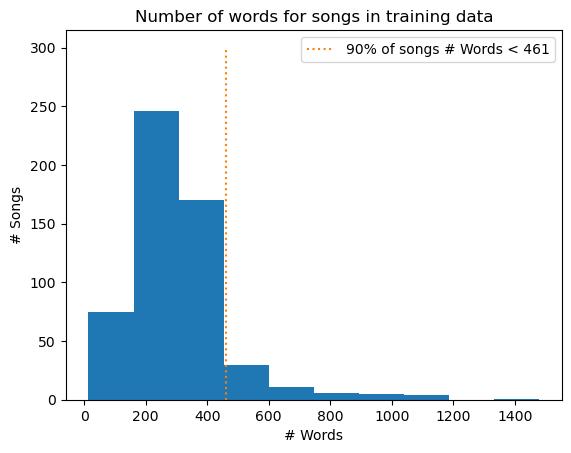

In [6]:
song_word_count = tokens.apply(len)

plt.figure()
plt.hist(song_word_count)
quantile_line = song_word_count.quantile(0.9)
plt.plot([quantile_line, quantile_line], [0, 300], ':',
         label=f"90% of songs # Words < {round(quantile_line)}")
plt.xlabel("# Words")
plt.ylabel("# Songs")
plt.title("Number of words for songs in training data")
plt.legend()
plt.show()

We'll use maximum sequence length = 600 but encourage the model with loss to output songs with around 450 words as this accounts for the overwhelming majority of songs in the corpus.

Note that the & sign designating a new line in the song was left the vocabulary to allow the model to reproduce the song structure and the seqence length takes this into account

In [7]:
corpus = pd.concat([tokens, tokenize_lyrics(validation.dataset["lyrics"]), tokenize_lyrics(test.dataset["lyrics"])]).reset_index(drop=True)

word2vec = Word2Vec(
  sentences=corpus,
  vector_size=300,
  window=5,
  min_count=1,
)
word2vec = word2vec.wv
word2vec.save("word2vec_lyrics.wordvectors")

word2vec = KeyedVectors.load("word2vec_lyrics.wordvectors", mmap='r')

In [8]:
class LyricsDataset(Dataset):
    def __init__(
        self,
        tokenized_lyrics: pd.Series(List[str]),
        midi_vectors: pd.Series(List[np.array]),
        word2vec,
        max_seq_length: int = 600,
    ):
        """
        Dataset object for lyrics.
        :param tokenized_lyrics: list of string tokens representing song lyrics
        :param midi_vectors: preprocess midi vectors
        :param word2vec: trained word2vec model
        :param max_seq_length: maximum length of lyrics tokens
        """
        self.tokenized_lyrics = tokenized_lyrics
        self.max_seq_length = max_seq_length
        self.match_seq_length()
        self.mid_vectors = []
        self.divide_midi(midi_vectors)
        self.model = word2vec
        self.vectorize_dataset()

    def match_seq_length(self):
        """
        Add padding or truncate the lyrics to match max_seq_length
        """
        for ind, lyrics in enumerate(self.tokenized_lyrics):
            if len(lyrics) > self.max_seq_length:
                lyrics = lyrics[:self.max_seq_length - len(lyrics) - 1] + ["eos"]
            else:
                lyrics += ["pad"] * (self.max_seq_length - len(lyrics))
            self.tokenized_lyrics[ind] = lyrics

    def vectorize_dataset(self):
        for ind, lyrics in enumerate(self.tokenized_lyrics):
            self.tokenized_lyrics[ind] = [
                self.model.key_to_index[token] for token in lyrics if token in self.model.key_to_index
            ]

    def __len__(self):
        return len(self.tokenized_lyrics)

    def __getitem__(self, index):
        tokens = self.tokenized_lyrics[index]
        input_seq = torch.tensor(np.array(tokens[:-1]), dtype=torch.long)
        target_seq = torch.tensor(np.array(tokens[1:]), dtype=torch.long)
        midi_vector = torch.tensor(np.array(self.mid_vectors[index][1:]), dtype=torch.float32) # to match length of words vectors
        return input_seq, target_seq, midi_vector

    def divide_midi(self, midi_vectors: pd.Series):
        for song_idx, song in self.tokenized_lyrics.items():
            duration_of_word = 1 / len(song)
            midi = []
            for idx, word in enumerate(song):
              if (word != "pad") and (word != "eos"):
                midi.append(LyricsDataset.get_midi(parsed_midi=midi_vectors[song_idx], idx=idx, duration=duration_of_word))
              else:
                midi.append(np.zeros(12))
            self.mid_vectors.append(midi)

    @staticmethod
    def get_midi(parsed_midi: pd.DataFrame, idx: int, duration:float) -> np.array:
        condition = np.logical_and(
            (parsed_midi[:, 0] >= float(idx * duration)),
            (parsed_midi[:, 1] <= float((idx + 1) * duration))
        )
        result = np.mean(parsed_midi[condition], axis=0)
        if (len(result) != 12) or (np.isnan(result).any()):
            result = np.zeros(12)
        return result


train_dataset = LyricsDataset(
    tokenize_lyrics(train.dataset["lyrics"]),
    midi_vectors=train.dataset.parsed_mid,
    max_seq_length=600,
    word2vec=word2vec
)

validation_dataset = LyricsDataset(
    tokenize_lyrics(validation.dataset["lyrics"]),
    midi_vectors=validation.dataset.parsed_mid,
    max_seq_length=600,
    word2vec=word2vec
)
test_dataset = LyricsDataset(
    tokenize_lyrics(test.dataset["lyrics"]),
    midi_vectors=test.dataset.parsed_mid,
    max_seq_length=600,
    word2vec=word2vec
)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"There are {len(train_dataset.model)} unique 'words' in the model\n"
f"This includes 4 special tokens (end of line, end of song, padding and chorus)")

C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Or\miniforge3\envs\deep_learning\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


There are 7465 unique 'words' in the model
This includes 4 special tokens (end of line, end of song, padding and chorus)


In [43]:
"""
Losses implementation + CombinedLoss class to return a weighted average
"""

def get_song(lyrics: List[str]):
    """
    Helper function that takes a list of strings including special tokens and returns the song as a single string
    """
    song = " ".join(lyrics).replace("eol ", "\n").replace("eos", "").strip()
    return song


class CosineSimilarityLoss(nn.Module):
    """
    Cosine Similarity value range is [-1, 1] and Loss value range is [0, 1]
    Similarity = 1 => loss = 0 and Similarity = -1 => loss = 1
    """
    def __init__(self):
        super(CosineSimilarityLoss, self).__init__()
        self.input_type = "embedding"
        self.similarity = nn.CosineSimilarity(dim=2)

    def forward(self, output, target, not_pad_mask):
        res = self.similarity(output, target)
        masked_res = res * not_pad_mask
        loss = (1 - masked_res.sum() / not_pad_mask.sum()) / 2
        return loss

class SentimentLoss(nn.Module):
    """
    Calculate loss based on a pre-trained Sentiment analysis model
    sentiment model polarity scores has compound values [-1, 1],
    and negative, positive, neutral values [0, 1].
    Sentiment loss per sample in batch are calculated as follows:
        sum(MSE(score) per score in [compound, negative, positive, neutral]) / max_error (= 7)
    This gives sample loss in range [0, 1]
    return average of losses in batch
    """
    def __init__(self, sentiment_model=SentimentIntensityAnalyzer()):
        super(SentimentLoss, self).__init__()
        self.input_type = "words"
        self.sid = sentiment_model

    def _get_scores(self, sequences):
        batch_scores = [
            list(self.sid.polarity_scores(
                get_song(sequences[seq_ind])
            ).values()) for seq_ind in range(sequences.shape[0])
        ]
        return np.array(batch_scores)

    def forward(self, output, target):
        # get score per sample in batch and calculate the average score
        output_scores = self._get_scores(output)
        target_scores = self._get_scores(target)

        # weighted_sentiment_loss range is [0, 2**2 + 3 = 7], divide by 7 for [0, 1] range
        sentiment_losses = np.mean(np.sum((output_scores - target_scores) ** 2, axis=1) / 7)
        return sentiment_losses


class LineLenLoss(nn.Module):
    """
    LineLenLoss: MSE between average line len per song in batch compared to target average line len - loss range [0, 1]
    """
    def __init__(self, end_of_line_token="eol", max_seq_len=600):
        super(LineLenLoss, self).__init__()
        self.input_type = "words"
        self.end_of_line_token = end_of_line_token
        self.max_seq_len = max_seq_len

    def _get_avg_line_lens(self, sequences):
        eol_mask = (sequences == self.end_of_line_token)
        eol_indices = [
            np.where(seq_eol_mask)[0] if np.any(seq_eol_mask) else np.array([self.max_seq_len])
            for seq_eol_mask in eol_mask
        ]
        avg_line_len = [
            np.mean(np.insert(np.diff(eol_index) - 1, 0, eol_index[0]))
            for eol_index in eol_indices
        ]
        return np.array(avg_line_len)

    def forward(self, output, target):
        # line length loss -
        output_avg_line_lens = self._get_avg_line_lens(output)
        target_avg_line_lens = self._get_avg_line_lens(target)

        line_len_loss = np.mean(
            abs(output_avg_line_lens - target_avg_line_lens) / self.max_seq_len
        )

        return line_len_loss


class SongLenLoss(nn.Module):
    """
    SongLenLoss: MSE error between song len and target song len - loss range [0, 1]
    """
    def __init__(self, end_of_song_token="eos", max_seq_len=600):
        super(SongLenLoss, self).__init__()
        self.input_type = "words"
        self.end_of_song_token = end_of_song_token
        self.max_seq_len = max_seq_len

    def _get_song_len(self, sequences):
        eos_mask = (sequences == self.end_of_song_token)
        return np.where(np.any(eos_mask, axis=1), np.argmax(eos_mask, axis=1), self.max_seq_len)

    def forward(self, output, target):
        # song length loss -
        output_song_len = self._get_song_len(output)
        target_song_len = self._get_song_len(target)

        max_len_error = np.maximum(target_song_len, self.max_seq_len - target_song_len) ** 2
        song_len_loss = np.mean((output_song_len - target_song_len) ** 2 / max_len_error)

        return song_len_loss
    
    
class DiversityLoss(nn.Module):
    """
    Penalize songs which use a small number of unique words to counter repeated word usage
    """
    def __init__(self):
        super(DiversityLoss, self).__init__()
        self.input_type = "words"

    def forward(self, output, target):
        unique_word_counts = [len(set(sequence)) for sequence in output]
        total_word_counts = [len(sequence) for sequence in output]
        
        # Calculate diversity as the ratio of unique words to total words
        diversity_ratios = np.array(unique_word_counts) / np.array(total_word_counts)
        diversity_loss = 1 - np.mean(diversity_ratios)
        
        return diversity_loss
    

class EntropyRegularizationLoss(nn.Module):
    """
    Penalize low entropy in song generation to promote less deterministic word selection
    """
    def __init__(self, vocab_size):
        super(EntropyRegularizationLoss, self).__init__()
        self.input_type = "logits"
        self.max_entropy = np.log(vocab_size)

    def forward(self, logits, target):
        # Compute softmax to get probabilities
        probs = torch.softmax(logits, dim=-1)
        entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=-1).mean()
        # Normalize entropy by the maximum entropy
        normalized_entropy = entropy / self.max_entropy
        entropy_loss = 1 - normalized_entropy
        
        return entropy_loss
    

class CombinedLyricsLoss(nn.Module):
    def __init__(
        self,
        word2vec,
        loss_func_list: List[nn.Module],
        loss_weights: List[float]
    ):
        super(CombinedLyricsLoss, self).__init__()
        self.word2vec = word2vec
        self.loss_func_list = loss_func_list
        self.loss_weights = loss_weights
        self.summed_weights = sum(loss_weights)
        self.cross_entropy = nn.CrossEntropyLoss()
        self.pad_idx = self.word2vec.key_to_index["pad"]

    def forward(self, logits, target, embedding_layer):
        device = logits.device
        batch_size, seq_len, vocab_size = logits.size()

        # Calculate CrossEntropyLoss
        ce_loss = self.cross_entropy(logits.view(-1, vocab_size), target.view(-1))

        # Get predicted words
        predicted_indices = torch.argmax(logits, dim=-1)
        predicted_words = np.array([
            [self.word2vec.index_to_key[idx.item()]
             for idx in sequence] for sequence in predicted_indices
        ])

        # Get target words
        target_words = np.array([
            [self.word2vec.index_to_key[idx.item()] for idx in sequence]
            for sequence in target
        ])

        # Get embeddings for predicted and target words
        predicted_embeddings = embedding_layer(predicted_indices)
        target_embeddings = embedding_layer(target)
        not_pad_mask = (target != self.pad_idx)

        weighted_loss = ce_loss.clone()

        for ind, loss_func in enumerate(self.loss_func_list):
            if self.loss_weights[ind] == 0:
                continue
            if loss_func.input_type == "words":
                loss = torch.tensor(loss_func(predicted_words, target_words), device=device)
            elif loss_func.input_type == "embedding":
                loss = loss_func(predicted_embeddings, target_embeddings, not_pad_mask)
            elif loss_func.input_type == "logits":
                loss = loss_func(logits, target)
            else:
                raise AssertionError("Loss function is missing input_type attribute")

            weighted_loss += self.loss_weights[ind] * loss

        return weighted_loss / (self.summed_weights + 1)  # +1 for CrossEntropyLoss


In [103]:
from tqdm import tqdm

    
class LyricsGAN(nn.Module):
    def __init__(
        self,
        word2vec,
        hidden_dim: int = 256,
        melody_hidden_dim: int = 128,
        rnn_type: str = "gru",
        n_rnn_layers: int = 3,
        dropout: float = 0.6,
        use_attention: bool = False,
        criterion = nn.CrossEntropyLoss(),
    ):
        """
        Generative Lyrics model including train and song generation methods
        :param word2vec: an initial word2vec model to use for the embedding layer
        :param melody_hidden_dim: hidden size of the melody layer
        :param hidden_dim: number of hidden nodes in the RNN architecture
        :param rnn_type: type of RNN cell ("lstm" or "gru")
        :param n_rnn_layers: Number of RNN layers in the RNN block
        :param dropout: dropout probability in the RNN cell
        :param use_attention: whether to use attention mechanism
        :param criterion: Loss function to use in training
        """
        super(LyricsGAN, self).__init__()

        self.word2vec_model = word2vec
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.criterion = criterion.to(self.device)
        self.use_attention = use_attention
        self.hidden_dim = hidden_dim
        self.melody_hidden_dim = melody_hidden_dim

        self.vector_size = word2vec.vector_size
        self.vocab_size = len(word2vec)

        embedding_matrix = np.zeros((self.vocab_size, self.vector_size))
        for word, idx in word2vec.key_to_index.items():
            embedding_matrix[idx] = word2vec[word]

        embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
        self.embedding = nn.Sequential(nn.Embedding.from_pretrained(embedding_matrix, freeze=True), nn.ReLU(inplace=True))


        # The "encoding" layer of the melody input
        self.melody_encoder = nn.Sequential(
            nn.Linear(12, melody_hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )
        if self.use_attention:
            # attention mechanisms for melody input
            self.melody_attention = nn.MultiheadAttention(melody_hidden_dim, num_heads=1, batch_first=True)
            # self-attention for sequence
            self.word_attention = nn.MultiheadAttention(self.vector_size, num_heads=1, batch_first=True)

        if rnn_type == "lstm":
            self.rnn_block = nn.LSTM(
                input_size=self.vector_size + melody_hidden_dim,
                hidden_size=hidden_dim,
                num_layers=n_rnn_layers,
                dropout=dropout,
                batch_first=True,
            )
        else:
            self.rnn_block = nn.GRU(
                input_size=self.vector_size + melody_hidden_dim,
                hidden_size=hidden_dim,
                num_layers=n_rnn_layers,
                dropout=dropout,
                batch_first=True,
            )
        
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.dense = nn.Linear(hidden_dim, self.vocab_size)

        self.to(self.device)
    
    def forward(self, x, melody_state, prev_state=None):
        b_size, seq_len = x.size()
        x_embbed = self.embedding(x)
        melody_state = self.melody_encoder(melody_state)
        
        if self.use_attention:
            if prev_state is None:
                query = torch.zeros(b_size, 1, self.hidden_dim).to(self.device)
            else:
                query = prev_state[0][-1].view(b_size, 1, self.melody_hidden_dim)
                
            melody_context, melody_attention = self.melody_attention(query, melody_state, melody_state)
            melody_context = melody_context.repeat(1, seq_len, 1)
            
            # mask future words so model won't rely on them when generating
            causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(self.device)
            word_context, word_attention = self.word_attention(x_embbed, x_embbed, x_embbed, attn_mask=causal_mask)
    
            combined_input = torch.cat((word_context, melody_context), dim=2)
        else:
            combined_input = torch.cat((x_embbed, melody_state), dim=2)
        
        output, state = self.rnn_block(combined_input, prev_state)
            
        output = self.bn(output.transpose(1, 2)).transpose(1, 2)  # apply batchnorm to the feature space
        logits = self.dense(output)
        return logits, state

    def train_model(
        self,
        train_loader,
        validation_loader,
        epochs: int,
        patience: int = 10,
        lr: float = 0.001
    ):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-5)
        self.train()
        losses = {"Train": [], "Validation": []}
        best_val_loss = float('inf')
        patience_counter = 0
        with tqdm(total=epochs, desc='Training') as pbar:
            for epoch in range(epochs):
                total_loss = torch.tensor(0.0, device=self.device)

                # Iterate over the train_loader (batches)
                for inputs, targets, midi_vectors in train_loader:
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    midi_vectors = midi_vectors.to(self.device)

                    optimizer.zero_grad()
                    logits, _ = self(inputs, midi_vectors)
                    
                    loss = combined_loss(logits, targets, model.embedding)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss

                avg_train_loss = total_loss.item() / len(train_loader)
                losses["Train"].append(avg_train_loss)

                # Validation loop
                self.eval()
                total_val_loss = torch.tensor(0.0, device=self.device)
                with torch.no_grad():
                    for inputs, targets, midi_vectors in validation_loader:
                        inputs = inputs.to(self.device)
                        targets = targets.to(self.device)
                        midi_vectors = midi_vectors.to(self.device)

                        logits, _ = self(inputs, midi_vectors)
                        
                        val_loss = combined_loss(logits, targets, model.embedding)
                        total_val_loss += val_loss

                avg_val_loss = total_val_loss.item() / len(validation_loader)
                losses["Validation"].append(avg_val_loss)

                # Early stopping
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_epoch = epoch + 1
                    patience_counter = 0
                    # Save the best model
                    torch.save(self.state_dict(), 'best_model.pth')
                else:
                    patience_counter += 1

                pbar.set_description(
                    f'Epoch {epoch+1}/{epochs}, '
                    f'Train Loss: {round(avg_train_loss, 4)}, '
                    f'Val Loss: {round(avg_val_loss, 4)}, '
                    f'BestVal Loss: {round(best_val_loss, 4)} (epoch {best_epoch})'
                )
                pbar.update(1)

                if patience_counter >= patience:
                    print(
                        f'\nEarly stopping triggered after {epoch + 1} '
                        f'epochs with best val loss = {round(best_val_loss, 4)}'
                    )
                    break

                if epoch % 25 == 0:
                    save_path = f'model_epoch_{epoch}.pth'
                    torch.save(self.state_dict(), save_path)

                    for i in range(3):
                      # Choose a random initial word and MIDI vector from the validation dataset to start a song
                      random_index = random.randint(0, len(validation_loader.dataset) - 1)
                      song_seed, _, melody = validation_loader.dataset[random_index]
                      song_seed = validation_loader.dataset.model.index_to_key[song_seed[0].item()]
                      generated_song = self.generate_song(song_seed, melody)
                      print(f"\nEpoch {epoch} - "
                            f"Generated Song (probabilistic) #{i + 1} - "
                            f"word count = {len(generated_song)}:"
                            f"\n{get_song(generated_song)}")

                # Set back to train mode
                self.train()

        return losses["Train"][:best_epoch], losses["Validation"][:best_epoch]

    def predict(self, input_seq, midi_vector, prev_state=None):
        """
        Predict method adds a dimension of probability to the predictions
        by sampling from the output logits.
        """
        self.eval()
        input_seq = input_seq.to(self.device)
        midi_vector = midi_vector.to(self.device)
        with torch.no_grad():
            logits, state = self(input_seq, midi_vector, prev_state=prev_state)

        probabilities = torch.softmax(logits, dim=-1)
        next_word_index = torch.multinomial(probabilities[0, -1], 1).item()

        return next_word_index, state

    def generate_song(self, initial_words: str, melody, max_length=600):
        """
        Support method to generate songs word-by-word starting from an initial word(s) input
        """
        generated_song = initial_words.split()
        current_indices = [
            self.word2vec_model.key_to_index[word] for word in generated_song
        ]
        current_indices = torch.tensor(np.array(current_indices)).unsqueeze(0)
        prev_state = None

        for i in range(max_length - len(generated_song)):
            current_midi = melody[i].unsqueeze(0).unsqueeze(0).to(self.device)
            next_word_index, state = self.predict(current_indices, current_midi, prev_state)

            next_word = self.word2vec_model.index_to_key[next_word_index]

            # if the predicted word is end-of-song token - stop the generation
            if next_word == "eos":
                break

            # Add the generated word to the song
            generated_song.append(next_word)

            # Predict the next word using the last word & the previous state
            current_indices = torch.tensor([next_word_index]).unsqueeze(0).to(self.device)
            prev_state = state

        return generated_song


In [104]:
combined_loss = CombinedLyricsLoss(
    word2vec=word2vec,
    loss_func_list=[
        CosineSimilarityLoss(),
        SentimentLoss(),
        LineLenLoss(),
        SongLenLoss(),
        DiversityLoss(),
        EntropyRegularizationLoss(vocab_size=(len(word2vec))),
    ],
    loss_weights=[0.5, 0.1, 0, 0.2, 0.2, 0.1]
)

model = LyricsGAN(word2vec=word2vec, criterion=combined_loss)
train_loss, val_loss = model.train_model(
    train_dataloader,
    validation_dataloader,
    epochs=100,
    lr=0.001,
    patience=10
)

Epoch 1/100, Train Loss: 2.102, Val Loss: 1.5618, BestVal Loss: 1.5618 (epoch 1):   1%|          | 1/100 [00:14<24:10, 14.65s/it]


Epoch 0 - Generated Song (probabilistic) #1 - word count = 600:
and forevers say on will wrong repeated bonny man lahaina settle oohooh horny guard pad j pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad yknow pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad holidays pad pad pad pad pad pad pad pad pad pad pad pad pad valley pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad

Epoch 26/100, Train Loss: 1.2418, Val Loss: 1.3639, BestVal Loss: 1.3624 (epoch 25):  26%|██▌       | 26/100 [06:11<17:46, 14.41s/it]


Epoch 25 - Generated Song (probabilistic) #1 - word count = 382:
have were there that so sent still weve 
its not numb under of healed all the lovers to both and to lose 
that i gathered up runnin of our mind and youve no tank call 
and the rain that just we used heaven we the kid 
take turn me weight our in school 
like started is and first theyre a fear goat mag 
so special in said shining and a hero no window 
every ayou sings you read up her rain man who in the roar 
are a house of rocky on where leaves in gold of the country rocky 
that wont may need the fuck bare 
i swear up the rest man to must up this who not run 
ive all no smile for his way that deep this bones 
its knows they can buy 
youre why make at soft in music ahuggin up shades and theyre life man for 
them gettin time always start already again through in walls 
but a zoot is that well hold the handle a abortion 
and broke into paper now a love ronron 
and the only i saw all things now baby 
and they know that end it

Epoch 35/100, Train Loss: 1.1116, Val Loss: 1.3877, BestVal Loss: 1.3624 (epoch 25):  35%|███▌      | 35/100 [08:23<15:35, 14.40s/it]


Early stopping triggered after 35 epochs with best val loss = 1.3624


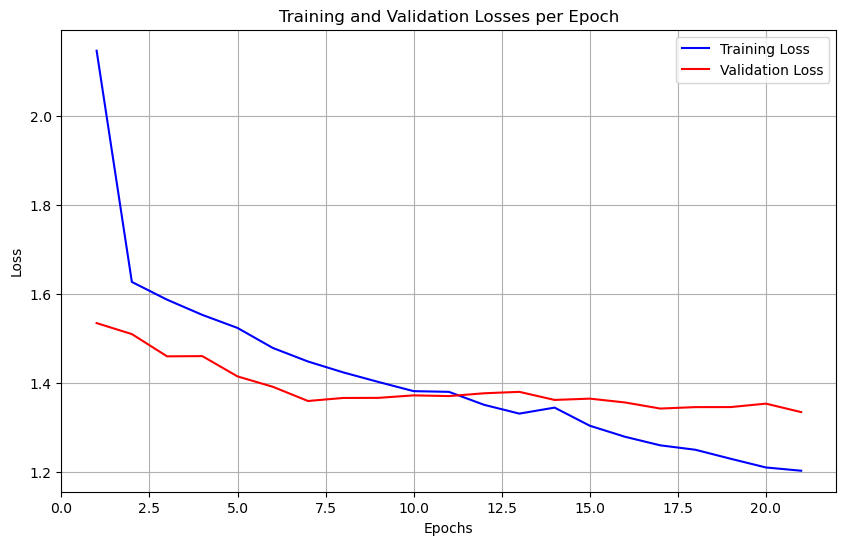

In [74]:
def plot_losses(train_losses, val_losses):
    """
    Plot training and validation losses per epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title('Training and Validation Losses per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
plot_losses(train_loss, val_loss)

In [75]:
def get_song_structure(song):
    line_lengths = [len(line.split()) for line in get_song(song).split('\n')]
    return len(line_lengths), np.mean(line_lengths) if line_lengths else 0


def get_diversity_score(sequence):
    unique_words = len(set(sequence))
    total_words = len(sequence)
    diversity_ratio = unique_words / total_words
    return diversity_ratio


def evaluate_model(model, dataloader, num_generations=5):
    model.eval()
    cosine_sim = nn.CosineSimilarity(dim=0)
    sentiment_loss = SentimentLoss()

    total_sentiment_similarity = 0
    total_cosine_similarity = 0
    total_structure_similarity = 0
    total_diversity_similarity = 0
    total_songs = len(dataloader)

    with torch.no_grad():
        for inputs, _, midi_vector in dataloader:
            inputs = inputs.to(model.device)
            midi_vector = midi_vector.to(model.device)

            original_song = [model.word2vec_model.index_to_key[idx.item()] for idx in inputs[0]] + ["pad"]
            first_word = original_song[0]

            song_sentiment_similarity = 0.0
            song_cosine_similarity = 0.0
            song_structure_similarity = 0.0
            song_diversity_similarity = 0.0

            for _ in range(num_generations):
                generated_song = model.generate_song(first_word, midi_vector[0])
                generated_song += ["pad"] * (len(original_song) - len(generated_song))

                # Calculate sentiment similarity using SentimentLoss
                sentiment_similarity = 1 - sentiment_loss(
                    np.array([generated_song]), np.array([original_song])
                )
                song_sentiment_similarity += sentiment_similarity

                # Calculate cosine similarity
                generated_indices = [
                    model.word2vec_model.key_to_index[word]
                    for word in generated_song if word in model.word2vec_model.key_to_index
                ]
                generated_vec = model.embedding(
                    torch.tensor(generated_indices).to(model.device)
                )
                original_vec = model.embedding(torch.cat((inputs, inputs[:, -1].unsqueeze(1)), dim=-1))

                cosine_similarity = torch.mean(cosine_sim(generated_vec, original_vec.squeeze(0))).item()
                song_cosine_similarity += cosine_similarity

                # Calculate structure similarity
                gen_song_len, gen_avg_line_len = get_song_structure(generated_song)
                orig_song_len, orig_avg_line_len = get_song_structure(original_song)
                
                # Calculate diversity similarity
                gen_diversity = get_diversity_score(generated_song)
                orig_diversity = get_diversity_score(original_song)
                diversity_similarity = 1 - abs(gen_diversity - orig_diversity) / max(gen_diversity, orig_diversity)
                song_diversity_similarity += diversity_similarity

                song_len_similarity = 1 - abs(gen_song_len - orig_song_len) / max(gen_song_len, orig_song_len)
                line_len_similarity = 1 - abs(gen_avg_line_len - orig_avg_line_len) / max(gen_avg_line_len, orig_avg_line_len)
                structure_similarity = (song_len_similarity + line_len_similarity) / 2
                song_structure_similarity += structure_similarity

            # Calculate average similarities for this song and add to the total score
            avg_song_sentiment_similarity = song_sentiment_similarity / num_generations
            avg_song_cosine_similarity = song_cosine_similarity / num_generations
            avg_song_structure_similarity = song_structure_similarity / num_generations
            avg_song_diversity_similarity = song_diversity_similarity / num_generations

            total_sentiment_similarity += avg_song_sentiment_similarity
            total_cosine_similarity += avg_song_cosine_similarity
            total_structure_similarity += avg_song_structure_similarity
            total_diversity_similarity += avg_song_diversity_similarity

    # Calculate overall averages for the dataset
    avg_sentiment_similarity = total_sentiment_similarity / total_songs
    avg_cosine_similarity = total_cosine_similarity / total_songs
    avg_structure_similarity = total_structure_similarity / total_songs
    avg_diversity_similarity = total_diversity_similarity / total_songs

    print(f"Average Sentiment Similarity: {avg_sentiment_similarity:.4f}")
    print(f"Average Cosine Similarity: {avg_cosine_similarity:.4f}")
    print(f"Average Structure Similarity: {avg_structure_similarity:.4f}")
    print(f"Average Diversity Similarity: {avg_diversity_similarity:.4f}")

    return avg_sentiment_similarity, avg_cosine_similarity, avg_structure_similarity, avg_diversity_similarity

In [109]:
model = LyricsGAN(word2vec=word2vec, criterion=combined_loss)
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint)

evaluate_model(model, test_dataloader)

Average Sentiment Similarity: 0.9229
Average Cosine Similarity: 0.2885
Average Structure Similarity: 0.6565
Average Diversity Similarity: 0.5980


(0.9228530356, 0.28850815236568456, 0.6564762205392218, 0.5979849750055599)

In [113]:
song_idx = 0
with torch.no_grad():
    for inputs, _, midi_vector in test_dataloader:
        inputs = inputs.to(model.device)
        midi_vector = midi_vector.to(model.device)
        
        original_song = [model.word2vec_model.index_to_key[idx.item()] for idx in inputs[0]]
        first_word = original_song[0]
        print(f"\nLyrics #{song_idx + 1} - Title: {test.dataset.title[song_idx]}\nSeed: {first_word}\n")
        generated_song = model.generate_song(first_word, midi_vector[0])
        print(get_song(generated_song))
        song_idx += 1
        


Lyrics #1 - Title:  eternal flame
Seed: close

close tempt in loneliness what chi me 
i never say what loved me 
im is love dont know never sorry 
i did say we i never talk 
be love its queen living 
shining it waiting i can hear 
look those magic of my life 
until i never think on this 
where used it true that change 
words this day 
another i could belong youd

Lyrics #2 - Title:  honesty
Seed: if

if another pinch at saviors 
the excelsis to were leave me 
just they be say my heart 
its it the meaning 
where a sirens wrong 
im been be 
and youve a butterfly too there before 
i be ever have your eyes 
i keep everything a world true 
of the time had to breathe 
throw from the couldnt 
tell me why to do you can 
you follow 
but how cannot real two 
never forget you 
if you never are you tight 
would you know i know that found i tenderly 
and its darling me tight for inside alone 
and loser to always in in way avenue in mine 
a things was i mend 
just youre try know together 
i would h

In [117]:
song_idx = 0
with torch.no_grad():
    for inputs, _, midi_vector in test_dataloader:
        inputs = inputs.to(model.device)
        midi_vector = midi_vector.to(model.device)
        
        for seed_word in ["happy" , "sad", "maybe"]:
            print(f"\nLyrics #{song_idx + 1} - Title: {test.dataset.title[song_idx]}\nSeed: {seed_word}\n")
            generated_song = model.generate_song(seed_word, midi_vector[0])
            print(get_song(generated_song))
            
        song_idx += 1


Lyrics #1 - Title:  eternal flame
Seed: happy

happy poco 
of the time of a refrain listen and though 
are we know this storm its him than

Lyrics #1 - Title:  eternal flame
Seed: sad

sad emotions 
know is my shadys soul way 
everyone gates 
life thinking for 
im in a life of here 
its been the year of piano 
the nigh rumblin to the 
the stars 
the your woman wind out 
ill fit of 
but this got in a highs 
find did not more 
sisters me sure 
why were loves 
still harder opened of silence telephone 
i had got a love jesus 
for rum in dancing 
oh its the music a mind 
purple him the world down by 
my dimension are ohohohohoh 
oh what a shoppers feeling 
hear he sea lonelier 
i have feel be off cry

Lyrics #1 - Title:  eternal flame
Seed: maybe

maybe teas to dont too one got your 
theres the a fancy eyes 
your romance weve changed 
so weve until their station 
loving again now a future 
i draw the law in lights 
when the pressures just knew 
i cry know her matters 
theres nothin behind 